### Install liten
Must install latest tendb before running the commands
Install from released package from pypi
```bash
$ pip install -i https://test.pypi.org/simple/ liten
```
Read local setup.py and install tendb
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten
```
Install from local wheel file
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten/dist/liten-0.0.1-py3-none-any.whl
```

Import Apache arrow

In [1]:
import pyarrow as pa
from pyarrow import csv
import json
import pandas as pd

Import Liten-ten is local rten is remote. rten imports pyarrow library as well.

In [2]:
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten.lib' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


Import Ray to be used as a cluster

In [3]:
import ray

Start a cluster with single worker.

In [4]:
ray.init(num_cpus=1)

2022-01-06 19:47:16,673	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.29.223.147',
 'raylet_ip_address': '172.29.223.147',
 'redis_address': '172.29.223.147:6379',
 'object_store_address': '/tmp/ray/session_2022-01-06_19-47-16_086363_8639/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-01-06_19-47-16_086363_8639/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-01-06_19-47-16_086363_8639',
 'metrics_export_port': 63229,
 'node_id': '82f700109db6fdf945138337386abe950809eeb8'}

In [5]:
ray.cluster_resources()

{'memory': 79.0,
 'object_store_memory': 27.0,
 'node:172.29.223.147': 1.0,
 'CPU': 1.0}

Create a Liten Cache Actor. It is residing on a remote node, and being executed on that node. tc is the Liten Cache actor handle.

In [6]:
ten.Cache = ray.remote(ten.Cache)
tc = ten.Cache.remote()

These are fact and dimension tables of TPCH. Read them remotely.

In [7]:
fact_tables = ['lineitem']
dim_tables = ['customer','orders','supplier','nation','region','partsupp','part']
tpch_dir = '/mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/'

In [8]:
def read_tables(tables, table_type):
    tc_tables = []
    for table_name in tables:
        tpch_table = tpch_dir+table_name+'.tbl'
        print('Reading ', tpch_table)
        csv_options = pa.csv.ParseOptions(delimiter='|')
        table = tc.read_csv.remote(input_file=tpch_table, parse_options=csv_options, table_name=table_name, ttype=table_type)
        # print(' Rows=', pytable.num_rows,' Cols=', pytable.num_columns)
        tc_tables.append(table)
    return tc_tables

In [9]:
%%time
fact_tables = ray.get(read_tables(fact_tables, ten.Cache.FactTable))
fact_tables

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/lineitem.tbl


(pid=8723) <frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten.lib' does not match runtime version 3.8
(pid=8723) <frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject
(pid=8723) WARNING: Logging before InitGoogleLogging() is written to STDERR
(pid=8723) I20220106 19:47:18.868999  8723 TCache.cpp:25] Created a new TCache


CPU times: user 302 ms, sys: 103 ms, total: 405 ms
Wall time: 7.38 s


(pid=8723) I20220106 19:47:26.035235  8723 TCatalog.cpp:15] Created a new TCatalog


['lineitem']

In [10]:
dim_tables = ray.get(read_tables(dim_tables, ten.Cache.DimensionTable))
dim_tables

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/customer.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/orders.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/supplier.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/nation.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/region.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/partsupp.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/part.tbl


['customer', 'orders', 'supplier', 'nation', 'region', 'partsupp', 'part']

In [11]:
ray.get(tc.info.remote())

b'{"Compute":{"WorkerThreads":0},"Table":{"part":"DimensionTable","partsupp":"DimensionTable","region":"DimensionTable","customer":"DimensionTable","lineitem":"FactTable","orders":"DimensionTable","supplier":"DimensionTable","nation":"DimensionTable"},"Schema":{"region_schema":"DimensionTable","part_schema":"DimensionTable","lineitem_schema":"FactTable","orders_schema":"DimensionTable","partsupp_schema":"DimensionTable","customer_schema":"DimensionTable","supplier_schema":"DimensionTable","nation_schema":"DimensionTable"}}'

In [12]:
pd.read_json(ray.get(tc.schema_info.remote()))

(pid=8723) I20220106 19:47:28.511760  8723 TConfigs.cpp:17] Created a new TConfigs


,Schema
customer_schema,DimensionTable
lineitem_schema,FactTable
nation_schema,DimensionTable
orders_schema,DimensionTable
part_schema,DimensionTable
partsupp_schema,DimensionTable
region_schema,DimensionTable
supplier_schema,DimensionTable


In [13]:
pd.read_json(ray.get(tc.schema_info.remote()))

,Schema
customer_schema,DimensionTable
lineitem_schema,FactTable
nation_schema,DimensionTable
orders_schema,DimensionTable
part_schema,DimensionTable
partsupp_schema,DimensionTable
region_schema,DimensionTable
supplier_schema,DimensionTable


Join all the parents and child of tensor dimensions and fact tables

In [14]:
ray.get(tc.join.remote('lineitem_schema','L_ORDERKEY','orders_schema','O_ORDERKEY'))
ray.get(tc.join.remote('lineitem_schema','L_SUPPKEY','supplier_schema','S_SUPPKEY'))
ray.get(tc.join.remote('orders_schema','O_CUSTKEY','customer_schema','C_CUSTKEY'))
ray.get(tc.join.remote('customer_schema','C_NATIONKEY','nation_schema','N_NATIONKEY'))
ray.get(tc.join.remote('nation_schema','N_REGIONKEY','region_schema','R_REGIONKEY'))
ray.get(tc.join.remote('supplier_schema','S_NATIONKEY', 'nation_schema', 'N_NATIONKEY'))

True

In [15]:
def get_schemas():
    schemas = { }
    def add_schema(table_name):
        schema_name = table_name + "_schema"
        schema_info = ray.get(tc.get_schema_info.remote(schema_name))
        schemas[schema_name] = json.loads(schema_info)
    for i in range(len(fact_tables)):
        add_schema(fact_tables[i])
    for i in range(len(dim_tables)):
        add_schema(dim_tables[i])
    return schemas

In [16]:
schemas = get_schemas()
pd.DataFrame(schemas['lineitem_schema']['schema'])

,fields,name,parent,type
L_COMMENT,"{'datatype': 'string', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_COMMITDATE,"{'datatype': 'date32[day]', 'type': 'MetricFie...",lineitem_schema,NaN,FactTable
L_DISCOUNT,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_EXTENDEDPRICE,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_LINENUMBER,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_LINESTATUS,"{'datatype': 'string', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_ORDERKEY,"{'datatype': 'int64', 'type': 'DimensionField'}",lineitem_schema,"[orders_schema, O_ORDERKEY]",FactTable
L_PARTKEY,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_QUANTITY,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_RECEIPTDATE,"{'datatype': 'date32[day]', 'type': 'MetricFie...",lineitem_schema,NaN,FactTable


In [17]:
pd.DataFrame(schemas['orders_schema']['schema'])

,child,fields,name,parent,type
O_ORDERKEY,"[lineitem_schema, L_ORDERKEY]","{'datatype': 'int64', 'type': 'DimensionField'}",orders_schema,NaN,DimensionTable
O_CLERK,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_COMMENT,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_CUSTKEY,NaN,"{'datatype': 'int64', 'type': 'DimensionField'}",orders_schema,"[customer_schema, C_CUSTKEY]",DimensionTable
O_ORDERDATE,NaN,"{'datatype': 'date32[day]', 'type': 'FeatureFi...",orders_schema,NaN,DimensionTable
O_ORDERPRIORITY,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_ORDERSTATUS,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_SHIPPRIORITY,NaN,"{'datatype': 'int64', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_TOTALPRICE,NaN,"{'datatype': 'double', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable


Create remote tensor

In [18]:
%%time
ray.get(tc.make_tensor.remote())

(pid=8723) I20220106 19:47:29.915287  8723 TTable.cpp:520] Created tensor for part
(pid=8723) I20220106 19:47:29.915331  8723 TTable.cpp:520] Created tensor for partsupp
(pid=8723) I20220106 19:47:29.915367  8723 TTable.cpp:520] Created tensor for region
(pid=8723) I20220106 19:47:30.202386  8723 TTable.h:355] Joined child table=customer col=C_NATIONKEY parent table=nation col=N_NATIONKEY
(pid=8723) I20220106 19:47:30.202455  8723 TTable.cpp:520] Created tensor for customer
(pid=8723) I20220106 19:47:39.411708  8723 TTable.h:355] Joined child table=lineitem col=L_ORDERKEY parent table=orders col=O_ORDERKEY
(pid=8723) I20220106 19:47:45.674350  8723 TTable.h:355] Joined child table=lineitem col=L_SUPPKEY parent table=supplier col=S_SUPPKEY
(pid=8723) I20220106 19:47:45.674420  8723 TTable.cpp:520] Created tensor for lineitem


CPU times: user 543 ms, sys: 304 ms, total: 847 ms
Wall time: 18.9 s


True

Read Arrow table

(pid=8723)  TPCH QUERY 6 
(pid=8723) SELECT 
(pid=8723)   SUM(L_EXTENDEDPRICE * L_DISCOUNT) AS REVENUE 
(pid=8723) FROM 
(pid=8723)   LINEITEM
(pid=8723) WHERE
(pid=8723)   L_SHIPDATE >= DATE '1997-01-01'
(pid=8723)   AND L_SHIPDATE < DATE '1997-01-01' + INTERVAL '1' YEAR
(pid=8723)   AND L_DISCOUNT BETWEEN 0.07 - 0.01 AND 0.07 + 0.01
(pid=8723)   AND L_QUANTITY < 25;
(pid=8723) 
(pid=8723) Revenue= 156594095.60960016
(pid=8723) 
(pid=8723) Time(ms)= 143.3903
(pid=8723) 


(pid=8723) I20220106 19:47:47.726487  8723 TTable.h:355] Joined child table=orders col=O_CUSTKEY parent table=customer col=C_CUSTKEY
(pid=8723) I20220106 19:47:47.726552  8723 TTable.cpp:520] Created tensor for orders
(pid=8723) I20220106 19:47:47.730736  8723 TTable.h:355] Joined child table=supplier col=S_NATIONKEY parent table=nation col=N_NATIONKEY
(pid=8723) I20220106 19:47:47.730762  8723 TTable.cpp:520] Created tensor for supplier
(pid=8723) I20220106 19:47:47.730811  8723 TTable.h:355] Joined child table=nation col=N_REGIONKEY parent table=region col=R_REGIONKEY
(pid=8723) I20220106 19:47:47.730824  8723 TTable.cpp:520] Created tensor for nation
(pid=8723) I20220106 19:47:47.744240  8723 TpchDemo.cpp:99] Found table lineitem in cache
(pid=8723) I20220106 19:47:47.744305  8723 TpchDemo.cpp:99] Found table customer in cache
(pid=8723) I20220106 19:47:47.744325  8723 TpchDemo.cpp:99] Found table orders in cache
(pid=8723) I20220106 19:47:47.744338  8723 TpchDemo.cpp:99] Found tabl

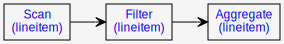

In [19]:
ray.get(tc.query6.remote())

In [20]:
ray.get(tc.query5.remote())

(pid=8723) I20220106 19:47:47.949774  8723 TpchDemo.cpp:99] Found table lineitem in cache
(pid=8723) I20220106 19:47:47.949821  8723 TpchDemo.cpp:99] Found table customer in cache
(pid=8723) I20220106 19:47:47.949836  8723 TpchDemo.cpp:99] Found table orders in cache
(pid=8723) I20220106 19:47:47.949843  8723 TpchDemo.cpp:99] Found table supplier in cache
(pid=8723) I20220106 19:47:47.949854  8723 TpchDemo.cpp:99] Found table nation in cache
(pid=8723) I20220106 19:47:47.949867  8723 TpchDemo.cpp:99] Found table region in cache


(pid=8723)  
(pid=8723) SELECT
(pid=8723) 	N_NAME,
(pid=8723) 	SUM(L_EXTENDEDPRICE * (1 - L_DISCOUNT)) AS REVENUE
(pid=8723) FROM
(pid=8723) 	CUSTOMER,
(pid=8723) 	ORDERS,
(pid=8723) 	LINEITEM,
(pid=8723) 	SUPPLIER,
(pid=8723) 	NATION,
(pid=8723) 	REGION
(pid=8723) WHERE
(pid=8723) 	C_CUSTKEY = O_CUSTKEY
(pid=8723) 	AND L_ORDERKEY = O_ORDERKEY
(pid=8723) 	AND L_SUPPKEY = S_SUPPKEY
(pid=8723) 	AND C_NATIONKEY = S_NATIONKEY
(pid=8723) 	AND S_NATIONKEY = N_NATIONKEY
(pid=8723) 	AND N_REGIONKEY = R_REGIONKEY
(pid=8723) 	AND R_NAME = 'EUROPE'
(pid=8723) 	AND O_ORDERDATE >= DATE '1995-01-01'
(pid=8723) 	AND O_ORDERDATE < DATE '1995-01-01' + INTERVAL '1' YEAR
(pid=8723) GROUP BY
(pid=8723) 	N_NAME
(pid=8723) ORDER BY
(pid=8723) 	REVENUE DESC;
(pid=8723) 


2022-01-06 19:48:07,959	WARNING worker.py:1034 -- A worker died or was killed while executing task ffffffffffffffffdf5a1a8201000000.


RayActorError: The actor died unexpectedly before finishing this task.

This will kill remote Liten Cache.

In [ ]:
ray.kill(tc)

Shut down ray now

In [ ]:
ray.shutdown()